# ACCESS-OM2 bolus transport and air-sea/mixing fluxes

Analysis of contribution of time-variable flows to temperature-latitude heat budget, overturning, diathermal fluxes

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37687/status,
Dashboard: /proxy/37687/status,Workers: 16
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43331,Workers: 16
Dashboard: /proxy/37687/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:43317,Total threads: 1
Dashboard: /proxy/39335/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:37267,


## Load data files and add some extra information (e.g. binning)

In [3]:
# files:
base = '/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_norediGM/';
outputs = ['output0' + str(x) + '/ocean/' for x in np.arange(84,85)]
fgrd   = xr.open_dataset(base + 'output084/ocean/ocean_grid.nc')

fwmass = xr.open_mfdataset([base + x + 'ocean_wmass.nc' for x in outputs]).chunk({'time': 1})
fmonth = xr.open_mfdataset([base + x + 'ocean_month.nc' for x in outputs]).chunk({'time': 1})
fheat  = xr.open_mfdataset([base + x + 'ocean_heat.nc' for x in outputs]).chunk({'yt_ocean':100}).chunk({'time': 1})
fwmass_mean = xr.open_mfdataset([base + x + 'ocean_wmass.ncra.nc' for x in outputs]).chunk({'grid_yt_ocean':100,'grid_yu_ocean':100}).isel(time=0)
fmonth_mean = xr.open_mfdataset([base + x + 'ocean_month.ncra.nc' for x in outputs]).chunk({'yt_ocean':100,'yu_ocean':100}).isel(time=0)
fheat_mean = xr.open_mfdataset([base + x + 'ocean_heat.ncra.nc' for x in outputs]).chunk({'yt_ocean':100}).isel(time=0)

# Generate xgcm grid object:
gridwm = Grid(fwmass,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fmonth,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_mean.neutral[1]-fwmass_mean.neutral[0]).values

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extrapolate').rename({'yt_ocean':'grid_yt_ocean'})

In [29]:
# Group SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.temp_rivermix_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)

fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.temp_rivermix + \
                      fheat_mean.sw_heat
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP   

In [30]:
# Do binning of time-mean:

# transport
temp_u = gridmn.interp(fmonth_mean.temp,'y',boundary='extend')-273.15
fwmass_mean["ty_trans_nrho_mean"] = gridmn.transform(fmonth_mean.ty_trans,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=temp_u).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# SF and MX:
fwmass_mean["SF_cv_mean"] = gridht.transform(fheat_mean.SF_cv,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=fmonth_mean.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["MX_cv_mean"] = gridht.transform(fheat_mean.MX_cv,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=fmonth_mean.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

In [6]:
# True streamfunction and heat function:
Psi = gridwm.cumsum(fwmass_mean.ty_trans_nrho.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0
Hf = -Cp*rho0*dT*gridwm.cumsum(Psi,'T',boundary="fill", fill_value=0)

# True surface forcing and vertical mixing:
SF = -gridwm.cumsum((fwmass_mean.SF_cv*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
MX = -gridwm.cumsum((fwmass_mean.MX_cv*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [31]:
# Same for time-mean:
Psi_mean = gridwm.cumsum(fwmass_mean.ty_trans_nrho_mean.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0
Hf_mean = -Cp*rho0*dT*gridwm.cumsum(Psi_mean,'T',boundary="fill", fill_value=0)

# True surface forcing and vertical mixing:
SF_mean = -gridwm.cumsum((fwmass_mean.SF_cv_mean*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
MX_mean = -gridwm.cumsum((fwmass_mean.MX_cv_mean*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [8]:
# Do the operations:
Psi.load();
Hf.load();
SF.load();
MX.load();

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.04 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.98 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.09 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [32]:
Psi_mean.load();
Hf_mean.load();
SF_mean.load();
MX_mean.load();

In [33]:
# Calculate eddy terms by residual:
Psi_eddy = Psi-Psi_mean;
Hf_eddy = Hf-Hf_mean;
SF_eddy = SF-SF_mean;
MX_eddy = MX-MX_mean;

In [62]:
# masking:
maskPsi = 0*Psi.where(Psi!=Psi.isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

<xarray.DataArray (neutralrho_edges: 75, grid_yt_ocean: 1080)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95

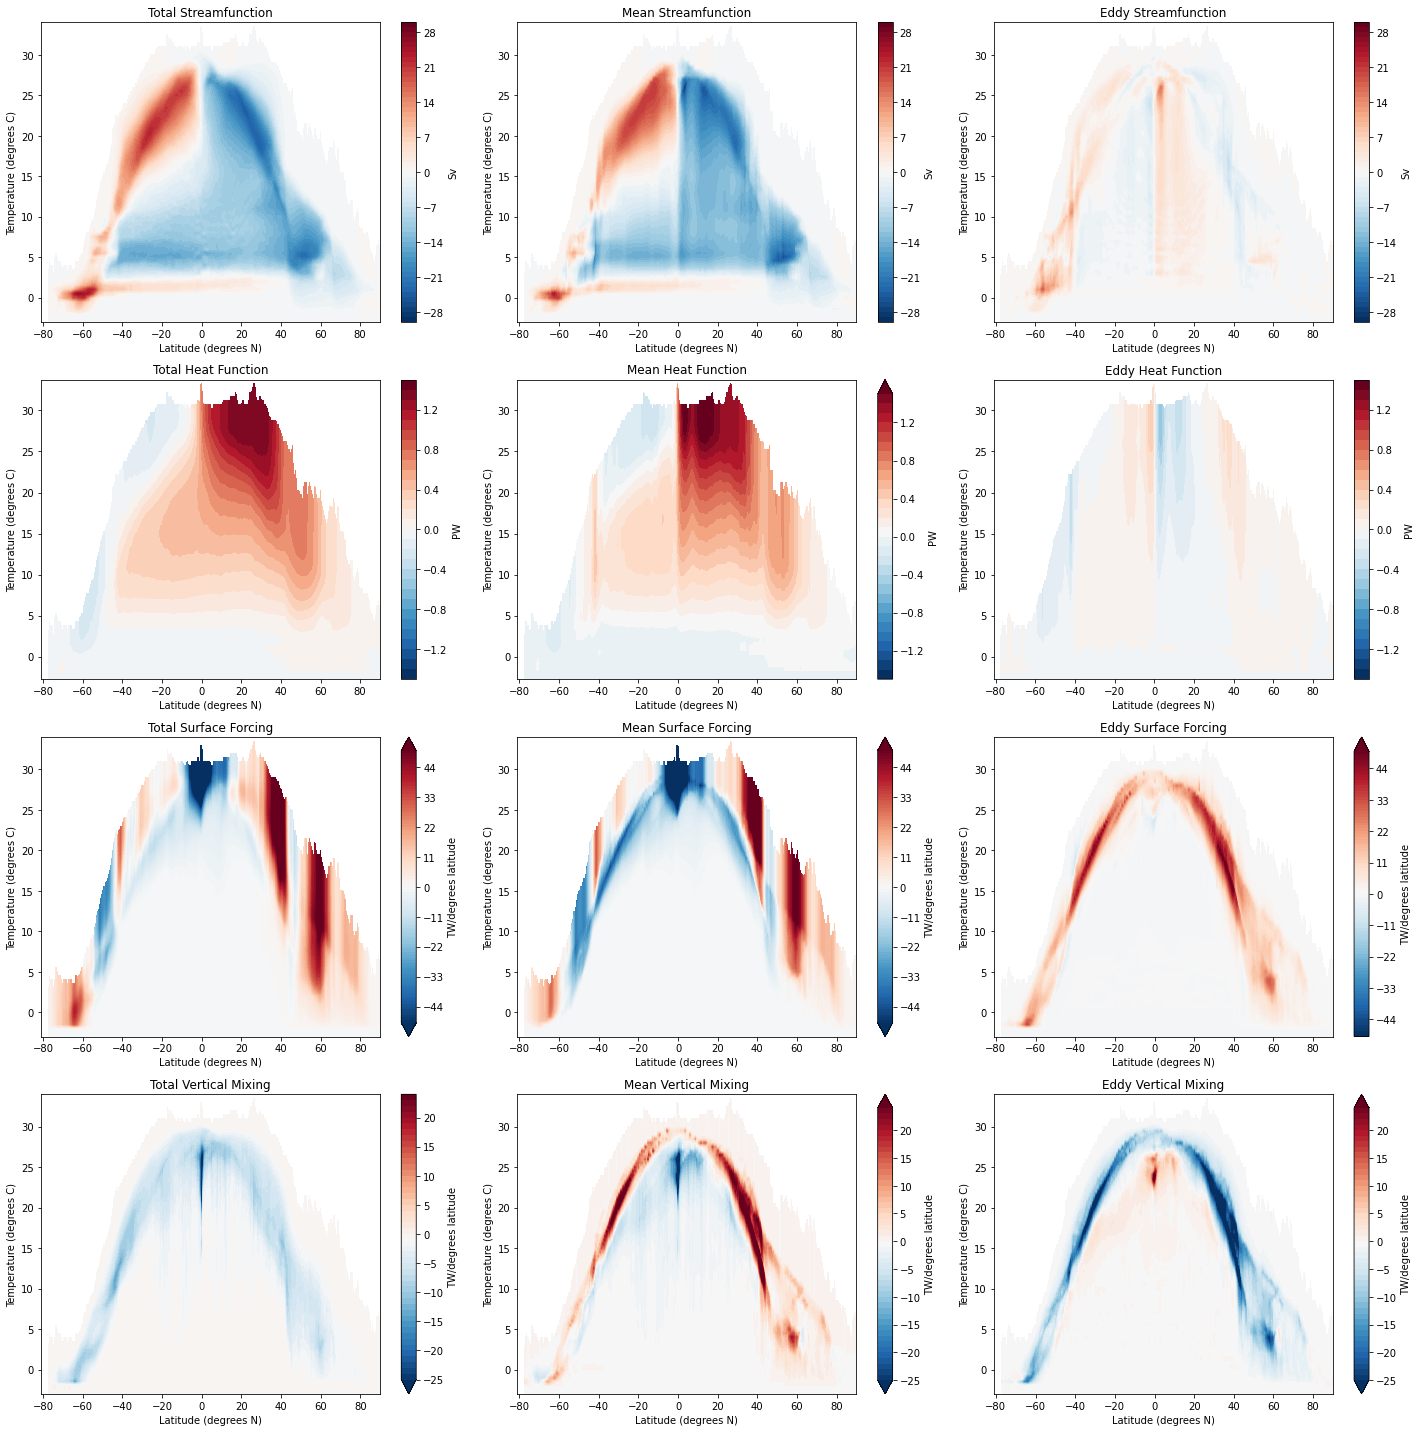

In [68]:
# Plotting:
plt.figure(figsize=(20,20))

Psicbar = np.arange(-30.,31.,1.)
Hfcbar = np.arange(-1.5,1.6,0.1)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

plt.subplot(4,3,1)
(Psi.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'})
plt.title('Total Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,2)
(Psi_mean.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'})
plt.title('Mean Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,3)
(Psi_eddy.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'})
plt.title('Eddy Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,4)
(Hf.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'})
plt.title('Total Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,5)
(Hf_mean.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'})
plt.title('Mean Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,6)
(Hf_eddy.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'})
plt.title('Eddy Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,7)
(SF.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'})
plt.title('Total Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,8)
(SF_mean.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'})
plt.title('Mean Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,9)
(SF_eddy.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'})
plt.title('Eddy Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,10)
(MX.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'})
plt.title('Total Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,11)
(MX_mean.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'})
plt.title('Mean Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,3,12)
(MX_eddy.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'})
plt.title('Eddy Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.tight_layout()
plt.savefig('ACCESS-OM2-025_norediGM_TotalMeanEddy_SfHfSFMX.png',dpi=100,bbox_inches='tight')

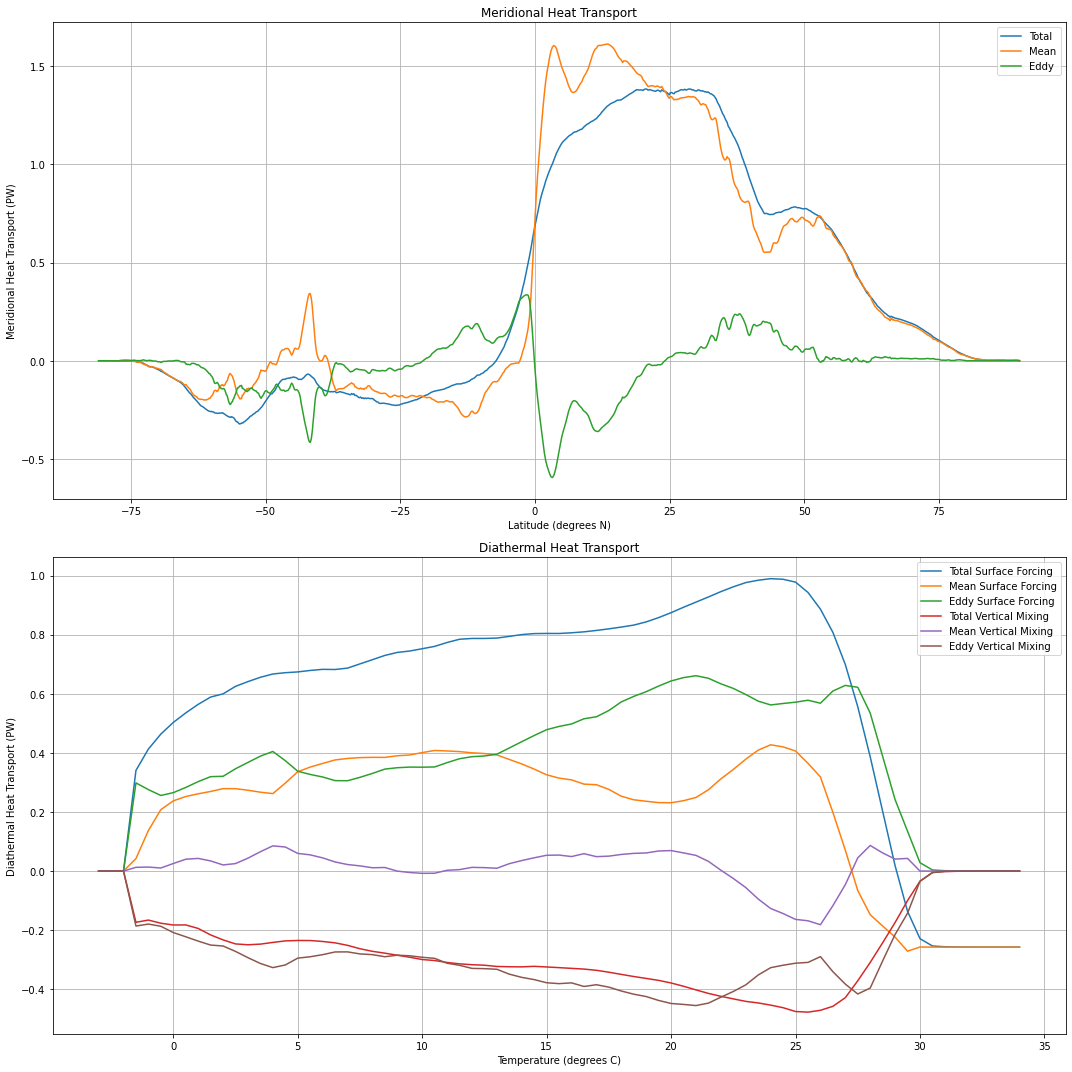

In [72]:
# Totals in temperature and meridional directions:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
(Hf/1.e15).isel(neutral=-1).plot(label='Total')
(Hf_mean/1.e15).isel(neutral=-1).plot(label='Mean')
(Hf_eddy/1.e15).isel(neutral=-1).plot(label='Eddy')
plt.legend()
plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('Meridional Heat Transport')
plt.grid()

plt.subplot(2,1,2)
(SF*dy/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing')
(SF_mean*dy/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing')
(SF_eddy*dy/1.e15).sum('grid_yt_ocean').plot(label='Eddy Surface Forcing')
(MX*dy/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing')
(MX_mean*dy/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing')
(MX_eddy*dy/1.e15).sum('grid_yt_ocean').plot(label='Eddy Vertical Mixing')
plt.legend()
plt.ylabel('Diathermal Heat Transport (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('Diathermal Heat Transport')
plt.grid()

plt.tight_layout()
plt.savefig('ACCESS-OM2-025_norediGM_TotalMeanEddy_SfHfSFMX_MHT_and_DHT.png',dpi=100,bbox_inches='tight')